# Self-Driving Car Engineer Nanodegree

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sbs
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.utils import shuffle

import scipy

---
## 1. Load The Data

In [2]:
import pickle

training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## 2. Dataset Summary & Exploration
 

In [3]:
n_train = y_train.shape[0]
n_validation = y_train.shape[0]
n_test = y_train.shape[0]
image_shape = X_test[0].shape
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 34799
Number of validation examples = 34799
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [4]:
def show_images(images_to_show, row=3, col=2, fig_size=(15, 6), is_index=True):
    f, axes = plt.subplots(row, col)
    f.set_size_inches(fig_size)
    for y in range(0, row):
        for x in range(0, col):
            ax = axes[y, x]
            ax.grid(b=None)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if y * col + x < len(images_to_show):
                img = images_to_show[y * col + x]
                if is_index:
                    img = img[1]
                ax.imshow(img)

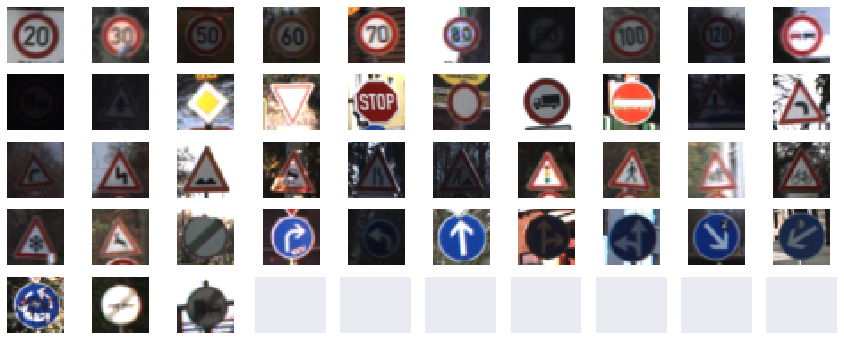

In [5]:
import random
import time

random.seed(int(time.time()))

images_examples = {}
elems = {}

# reservoir sampling, reservoir size = 1
for x, y in zip(X_train, y_train):
    if y in images_examples.keys():
        if random.randint(0, elems[y]) < 1:
            images_examples[y] = x
            elems[y] = elems[y] + 1
    else:
        images_examples[y] = x
        elems[y] = 1
    
import operator
traffic_signs = sorted(images_examples.items(), key=operator.itemgetter(0))

show_images(traffic_signs, row=5, col=10)

Check if the number of classes within sets is well balanced

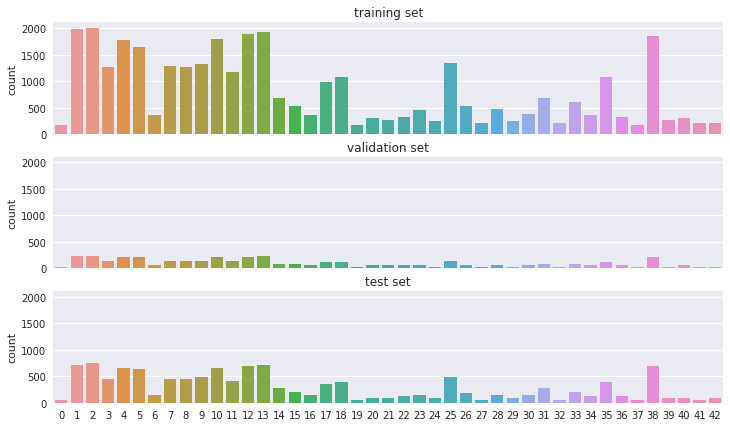

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
sbs.countplot(x=y_train, ax=ax1)
ax1.title.set_text('training set')
sbs.countplot(x=y_valid, ax=ax2)
ax2.title.set_text('validation set')
sbs.countplot(x=y_test, ax=ax3)
ax3.title.set_text('test set')
f.set_size_inches((12, 7))
plt.show()

In [7]:
label_counts = pd.DataFrame(data = {'label' : y_train})
label_counts['label'].value_counts().describe()

count      43.000000
mean      809.279070
std       626.750855
min       180.000000
25%       285.000000
50%       540.000000
75%      1275.000000
max      2010.000000
Name: label, dtype: float64

---
## 3. Data augmentation

In [8]:
import cv2
import random

def rotate_img(img, s_angle=-10, end_angle=10):
    tmp = scipy.misc.imresize(img, 1.5)
    angle = random.randint(s_angle, end_angle)
    tmp = scipy.misc.imrotate(tmp, angle)
    
    if angle < 0:
        pass
    
    crop = int(abs(0.5 * angle)) + 1
    return scipy.misc.imresize(tmp[crop:-crop, crop:-crop,], (32, 32))

def crop(img, c_lx, c_rx, c_ly, c_ry):
    return scipy.misc.imresize(img[c_lx:-c_rx, c_ly:-c_ry,], (32, 32))

def augment_simplified(img):
    crop_min = 1
    crop_max = 5
    lx = random.randint(crop_min, crop_max)
    ly = random.randint(crop_min, crop_max)
    rx = random.randint(crop_min, crop_max)
    ry = random.randint(crop_min, crop_max)
    img = crop(img, lx, rx, ly, ry)
    
    img = rotate_img(img)
    return img

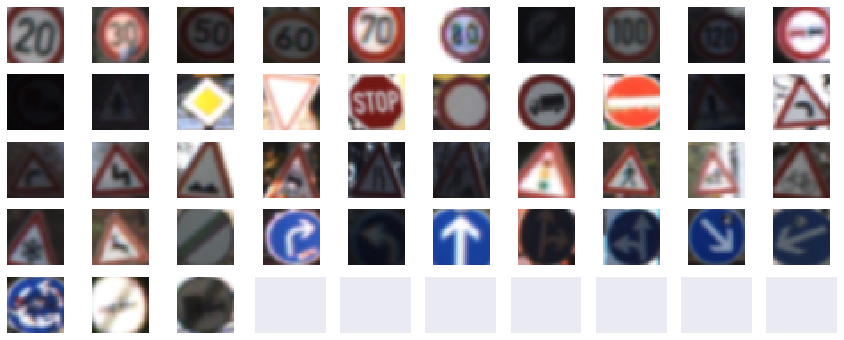

In [9]:
augmented = [(img[0], augment_simplified(img[1])) for img in traffic_signs]
show_images(augmented, row=5, col=10)

In [10]:
import sys

labels_to_generate = 540

def get_images_with_label(X, y, label):
    images = []
    for img_x, lab_y in zip(X, y):
        if lab_y == label:
            images.append(img_x)
    return np.asarray(images)

for y in set(y_train):
    images_with_label = get_images_with_label(X_train, y_train, y)
    label_count = len(images_with_label)
    while label_count < labels_to_generate:
        for i, image in enumerate(images_with_label):
            if label_count > labels_to_generate:
                break
            sys.stdout.write('label = {}, label_count = {}/{} \r'.format(y, label_count, labels_to_generate))
            sys.stdout.flush()
            img = augment_simplified(image)
            X_train = np.append(X_train, img.reshape(1, 32, 32, 3), axis=0)
            y_train = np.append(y_train, np.asarray(y).reshape(1), axis=0)
            label_count = label_count + 1

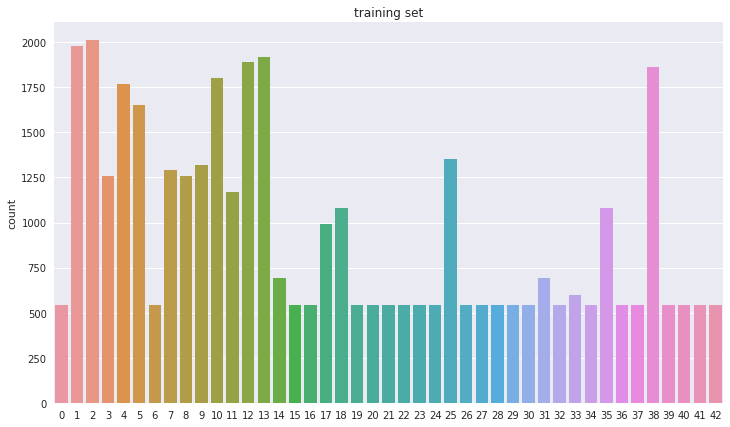

In [11]:
f, ax1 = plt.subplots(1, sharex=True, sharey=True)
sbs.countplot(x=y_train, ax=ax1)
ax1.title.set_text('training set')
f.set_size_inches((12, 7))
plt.show()

## 4. Preprocessing

In [12]:
def normalize_hist(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3, 3))
    img[:,:,0] = clahe.apply(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

def convert_to_gray(img):
    img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
    return np.expand_dims(img, 3)

def min_max_normalize(img):
    return (img - np.full(img.shape, 128, dtype='float32'))/128

def preprocess(img):
    img = normalize_hist(img)
    img = convert_to_gray(img)
    img = min_max_normalize(img)
    return img

In [13]:
X_train_list = []
for i, img in enumerate(X_train):
    X_train_list.append(preprocess(img))
    
X_valid_list = []
for i, img in enumerate(X_valid):
    X_valid_list.append(preprocess(img))
    
X_test_list = []
for i, img in enumerate(X_test):
    X_test_list.append(preprocess(img))
    
X_train = np.asarray(X_train_list)
X_valid = np.asarray(X_valid_list)
X_test = np.asarray(X_test_list)

## 4. Define Model Architectures

For the purpose of this project let's compare the performace of the LeNet (baseline) from the task description and AlexNet - another famous neural network architecture. 

In [68]:
from tensorflow.contrib.layers import flatten

conv_layers = []

def conv2d(x, f_size, no_filters, stride, name, mu = 0, sigma = 0.1, padding='VALID'):
    no_channels = int(x.get_shape()[-1])
    
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(
            tf.truncated_normal(shape=(f_size, f_size, no_channels, no_filters),
            mean = mu, stddev = sigma
        ), name="weights")
        
        biases = tf.Variable(tf.zeros(no_filters), name="biases")
        conv = tf.nn.conv2d(x, weights, strides = [1, stride, stride, 1], padding = padding) + biases
        
        relu = tf.nn.relu(conv, name = scope.name)
        conv_layers.append(relu)
        
        return relu


def fc(x, ins, outs, name, is_relu=True, mu = 0, sigma = 0.1):
    with tf.variable_scope(name) as scope:
        weights =  tf.Variable(tf.truncated_normal(shape=(ins, outs), mean = mu, stddev = sigma), name="weights")        
        biases = tf.Variable(tf.zeros(outs), name="biases")
    
        act = tf.matmul(x, weights) + biases
        
        if is_relu:
            return tf.nn.relu(act)
        return act
    
def lrn(x, radius, alpha, beta, name, bias=1.0):
      return tf.nn.local_response_normalization(x, depth_radius = radius,
                                            alpha = alpha, beta = beta,
                                            bias = bias, name = name)


def MyNet(x, keep_prob, mu = 0, sigma = 0.1):
    
    # Layer 1: Convolution
    conv1 = conv2d(x, 7, 24, 1, 'conv1')
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = lrn(conv1, 2, 2e-05, 0.75, name = 'norm1')
    
    # Layer 2: Convolution
    conv2 = conv2d(conv1, 3, 32, 1, 'conv2')

    # Layer 3: Convolution
    conv3 = conv2d(conv2, 3, 32, 1, 'conv3')
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv3 = lrn(conv3, 2, 2e-05, 0.75, name = 'norm3')

    # Flatten
    fc0 = flatten(conv3)
    fc0 = tf.nn.dropout(fc0, keep_prob)

    # Layer 3: Fully Connected
    fc1 = fc(fc0, 512, 512, 'fc1')
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected
    fc2 = fc(fc1, 512, 512, 'fc2')
    fc2 = tf.nn.dropout(fc2, keep_prob)

    #fc3 = fc(fc2, 256, 128, 'fc3')
    #fc3 = tf.nn.dropout(fc3, keep_prob)
    
    # Layer 6: Fully Connected
    return fc(fc2, 512, 43, 'logits', False)

In [69]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [70]:
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 128

In [71]:
logits = MyNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'weight' in v.name]) * 0.001
loss_operation = tf.reduce_mean(cross_entropy + lossL2)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [72]:
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

In [73]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [74]:
training_acc = []
validation_acc = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        sys.stdout.write('Epoch = {}, valid_acc = {:0.3f}, train_acc = {:0.3f}'.format(
            i + 1, validation_accuracy, training_accuracy)
        )
        sys.stdout.flush()
        training_acc.append(training_accuracy)
        validation_acc.append(validation_accuracy)
        print()
        
    print("Test set accuracy: ", evaluate(X_test, y_test))
    saver.save(sess, './lenet')
    print("Model saved")

Training...
Epoch = 1, valid_acc = 0.846, train_acc = 0.852
Epoch = 2, valid_acc = 0.941, train_acc = 0.949
Epoch = 3, valid_acc = 0.958, train_acc = 0.967
Epoch = 4, valid_acc = 0.963, train_acc = 0.979
Epoch = 5, valid_acc = 0.978, train_acc = 0.986
Epoch = 6, valid_acc = 0.982, train_acc = 0.990
Epoch = 7, valid_acc = 0.984, train_acc = 0.991
Epoch = 8, valid_acc = 0.968, train_acc = 0.992
Epoch = 9, valid_acc = 0.982, train_acc = 0.992
Epoch = 10, valid_acc = 0.985, train_acc = 0.994
Test set accuracy:  0.967933491611
Model saved


---

## 5: Test a Model on New Images


### Load and Output the Images

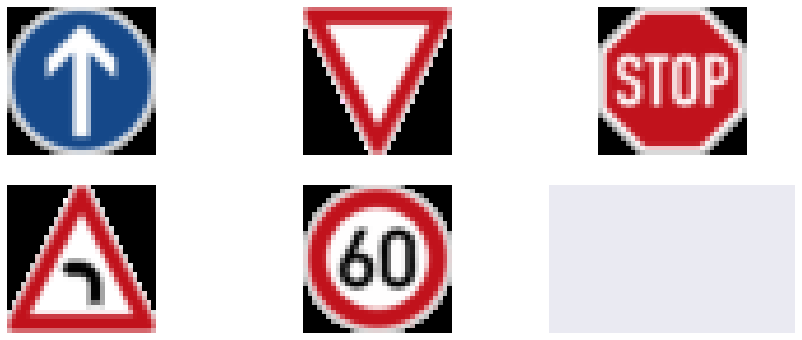

In [176]:
test_images_labels = [35, 13, 14, 19, 3]
test_images = []

for i in range(1, 6):
    image = scipy.misc.imread("testing/{}.png".format(i))
    image_resized = scipy.misc.imresize(image, (32, 32))
    image_no_alpha = image_resized[:,:,:3]
    test_images.append(image_no_alpha)
show_images(test_images, row=2, col=3, is_index=False)

In [177]:
sig_names = pd.read_csv("signnames.csv")
sig_names[sig_names.ClassId.isin(test_images_labels)]

,ClassId,SignName
3,3,Speed limit (60km/h)
13,13,Yield
14,14,Stop
19,19,Dangerous curve to the left
35,35,Ahead only


### Predict the Sign Type for Each Image

In [178]:
saver = tf.train.Saver()

# preprocess
preprocessed = []
for img in test_images:
    img = preprocess(img)
    preprocessed.append(img)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    saver.restore(sess, "./lenet")
    prediction = sess.run(
        tf.argmax(tf.nn.softmax(logits), dimension=1),
        feed_dict={x: preprocessed, keep_prob: 1.0}
    )

### Analyze Performance

In [179]:
test_images_labels

[35, 13, 14, 19, 3]

In [180]:
prediction

array([35, 13, 14, 19,  3])

In [181]:
np.sum(test_images_labels == prediction)/prediction.shape[0] * 100

100.0

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [182]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    saver.restore(sess, "./lenet")
    prediction = sess.run(
        tf.nn.top_k(tf.nn.softmax(logits), k=5),
        feed_dict={x: preprocessed, keep_prob: 1.0}
    )
    print(prediction)

TopKV2(values=array([[  9.99999881e-01,   6.70376608e-08,   1.47275410e-08,
          2.03907224e-09,   2.03434469e-09],
       [  1.00000000e+00,   1.00927009e-08,   8.79468676e-09,
          1.87688798e-09,   1.36122247e-09],
       [  9.88652647e-01,   1.03701390e-02,   2.72338133e-04,
          2.22566930e-04,   1.74618166e-04],
       [  1.00000000e+00,   5.53551835e-08,   2.51540981e-15,
          1.90828667e-15,   6.76442841e-16],
       [  9.99757588e-01,   8.54175232e-05,   5.75403246e-05,
          4.87711914e-05,   1.79083800e-05]], dtype=float32), indices=array([[35, 36, 34, 29,  0],
       [13, 36, 12, 32, 39],
       [14, 18,  1, 38,  2],
       [19, 23, 29, 31,  0],
       [ 3,  1, 38,  5,  0]], dtype=int32))


---

## 6: Visualize the Neural Network's State with Test Images

In [183]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

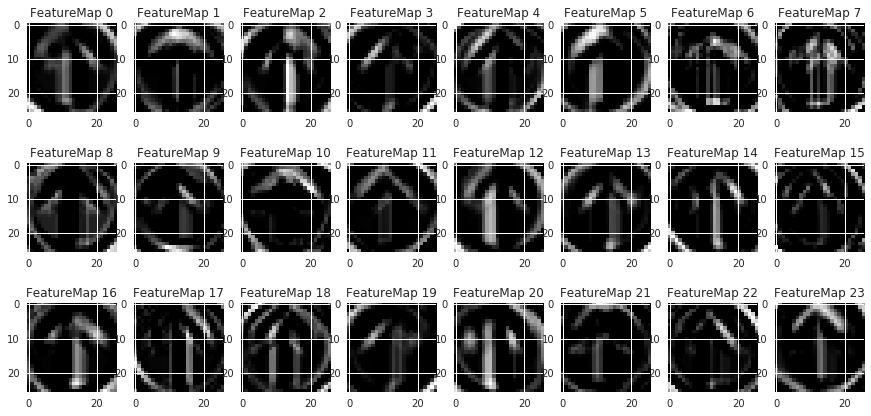

In [188]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    saver.restore(sess, "./lenet")
    outputFeatureMap(preprocessed[0].reshape(1, 32, 32, 1), conv_layers[0], plt_num=3)

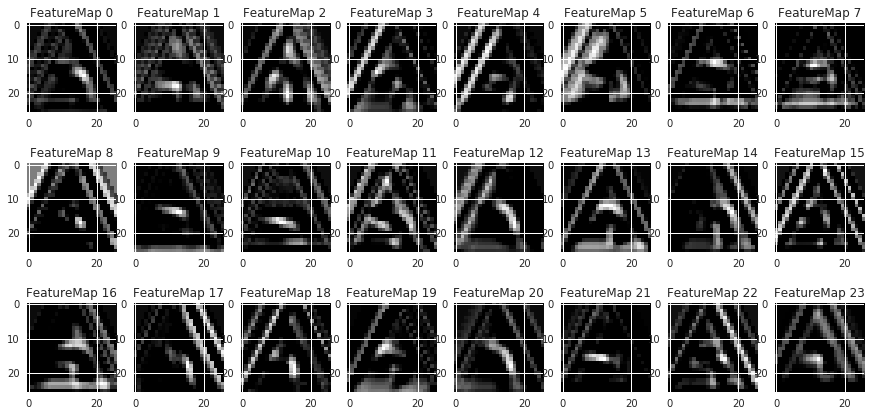

In [189]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    saver.restore(sess, "./lenet")
    outputFeatureMap(preprocessed[3].reshape(1, 32, 32, 1), conv_layers[0], plt_num=3)